# Table of Contents
* [Assignment 3: Neural Network Regression with tanh and relu](#Assignment-3:-Neural-Network-Regression-with-tanh-and-relu)
	* [Overview](#Overview)
	* [Neural Network Code](#Neural-Network-Code)
	* [Neural Network Performance with Different Hidden Layer Structures and Numbers of Training Iterations](#Neural-Network-Performance-with-Different-Hidden-Layer-Structures-and-Numbers-of-Training-Iterations)
		* [Example with Toy Data](#Example-with-Toy-Data)
		* [Experiments with Automobile Data](#Experiments-with-Automobile-Data)
	* [Experiments with relu activation function](#Experiments-with-relu-activation-function)
	* [Text descriptions](#Text-descriptions)
	* [Grading and Check-in](#Grading-and-Check-in)
	* [Extra Credit](#Extra-Credit)


$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 3: Neural Network Regression with tanh and relu

Lucas Wilson

## Overview

The goal of this assignment is to 
   * gain some experience in comparing different sized neural networks when applied to a data set, 
   * implement a different activation function, relu, and compare with Tanh, and
   * learn about object-oriented programming in python and to gain some experience in comparing different sized neural networks when applied to a data set.

Starting with the ```NeuralNetwork``` class from the lecture notes, you will create a new version of that class, apply it to a data set, and discuss the results. You will then create a second version, named ```NeuralNetwork_relu```, that uses the relu activation function instead of the tanh function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Neural Network Code

In [2]:
%%writefile neuralnetworks.py

"""
np.atan and its derivative have been replaced by methods in the class. They can
now be extedned and overloaded. See bottom for my overload with ReLU.
"""

import numpy as np
import mlutilities as ml
import matplotlib.pyplot as plt
from copy import copy
import time


class NeuralNetwork:

    def __init__(self, ni, nhs, no):

        if isinstance(nhs, list) or isinstance(nhs, tuple):
            if len(nhs) == 1 and nhs[0] == 0:
                nihs = [ni]
                nhs = []
            else:
                nihs = [ni] + list(nhs)
        else:
            if nhs > 0:
                nihs = [ni, nhs]
                nhs = [nhs]
            else:
                nihs = [ni]
                nhs = []

        if len(nihs) > 1:
            self.Vs = [1/np.sqrt(nihs[i]) *
                       np.random.uniform(-1, 1, size=(1 + nihs[i], nihs[i + 1])) for i in range(len(nihs) - 1)]
            self.W = 1/np.sqrt(nhs[-1]) * np.random.uniform(-1, 1, size=(1 + nhs[-1], no))
        else:
            self.Vs = []
            self.W = 1 / np.sqrt(ni) * np.random.uniform(-1, 1, size=(1 + ni, no))
        self.ni, self.nhs, self.no = ni, nhs, no
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        self.trained = False
        self.reason = None
        self.errorTrace = None
        self.numberOfIterations = None
        self.trainingTime = None

    def __repr__(self):
        str = 'NeuralNetwork({}, {}, {})'.format(self.ni, self.nhs, self.no)
        # str += '  Standardization parameters' + (' not' if self.Xmeans == None else '') + ' calculated.'
        if self.trained:
            str += '\n   Network was trained for {} iterations that took {:.4f} seconds. Final error is {}.'.format(self.numberOfIterations, self.getTrainingTime(), self.errorTrace[-1])
        else:
            str += '  Network is not trained.'
        return str

    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _standardizeT(self, T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:, self.Tconstant] = 0.0
        return result

    def _unstandardizeT(self, Ts):
        return self.Tstds * Ts + self.Tmeans

    def _pack(self, Vs, W):
        return np.hstack([V.flat for V in Vs] + [W.flat])

    def _unpack(self, w):
        first = 0
        numInThisLayer = self.ni
        for i in range(len(self.Vs)):
            self.Vs[i][:] = w[first:first + (1 + numInThisLayer) * 
                              self.nhs[i]].reshape((1 + numInThisLayer, self.nhs[i]))
            first += (numInThisLayer+1) * self.nhs[i]
            numInThisLayer = self.nhs[i]
        self.W[:] = w[first:].reshape((1 + numInThisLayer, self.no))

    def _objectiveF(self, w, X, T):
        self._unpack(w)
        # Do forward pass through all layers
        Zprev = X
        for i in range(len(self.nhs)):
            V = self.Vs[i]
            Zprev = self.activation(Zprev @ V[1:, :] + V[0:1, :])  # handling bias weight without adding column of 1's
        Y = Zprev @ self.W[1:, :] + self.W[0:1, :]
        return 0.5 * np.mean((T - Y)**2)

    def _gradientF(self, w, X, T):
        self._unpack(w)
        # Do forward pass through all layers
        Zprev = X
        Z = [Zprev]
        for i in range(len(self.nhs)):
            V = self.Vs[i]
            Zprev = self.activation(Zprev @ V[1:, :] + V[0:1, :])
            Z.append(Zprev)
        Y = Zprev @ self.W[1:, :] + self.W[0:1, :]
        # Do backward pass, starting with delta in output layer
        delta = -(T - Y) / (X.shape[0] * T.shape[1])
        dW = np.vstack((np.ones((1, delta.shape[0])) @ delta, 
                        Z[-1].T @ delta))
        dVs = []
        delta = (self.activation_derivative(Z[-1])) * (delta @ self.W[1:, :].T)
        for Zi in range(len(self.nhs), 0, -1):
            Vi = Zi - 1  # because X is first element of Z
            dV = np.vstack((np.ones((1, delta.shape[0])) @ delta,
                            Z[Zi-1].T @ delta))
            dVs.insert(0, dV)
            delta = (delta @ self.Vs[Vi][1:, :].T) * (1 - Z[Zi-1]**2)
        return self._pack(dVs, dW)

    def train(self, X, T, nIterations=100, verbose=False,
              weightPrecision=0, errorPrecision=0, saveWeightsHistory=False):
        
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1
        X = self._standardizeX(X)

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
        T = self._standardizeT(T)

        startTime = time.time()

        scgresult = ml.scg(self._pack(self.Vs, self.W),
                            self._objectiveF, self._gradientF,
                            X, T,
                            xPrecision=weightPrecision,
                            fPrecision=errorPrecision,
                            nIterations=nIterations,
                            verbose=verbose,
                            ftracep=True,
                            xtracep=saveWeightsHistory)
        self._unpack(scgresult['x'])
        self.reason = scgresult['reason']
        self.errorTrace = np.sqrt(scgresult['ftrace']) # * self.Tstds # to _unstandardize the MSEs
        self.numberOfIterations = len(self.errorTrace)
        self.trained = True
        self.weightsHistory = scgresult['xtrace'] if saveWeightsHistory else None
        self.trainingTime = time.time() - startTime
        return self

    def use(self, X, allOutputs=False):
        Zprev = self._standardizeX(X)
        Z = [Zprev]
        for i in range(len(self.nhs)):
            V = self.Vs[i]
            Zprev = self.activation(Zprev @ V[1:, :] + V[0:1, :])
            Z.append(Zprev)
        Y = Zprev @ self.W[1:, :] + self.W[0:1, :]
        Y = self._unstandardizeT(Y)
        return (Y, Z[1:]) if allOutputs else Y

    def getNumberOfIterations(self):
        return self.numberOfIterations

    def getErrors(self):
        return self.errorTrace

    def getTrainingTime(self):
        return self.trainingTime

    def getWeightsHistory(self):
        return self.weightsHistory

    def draw(self, inputNames=None, outputNames=None, gray=False):
        ml.draw(self.Vs, self.W, inputNames, outputNames, gray)
        
    def activation(self, weighted_sum):
        return np.tanh(weighted_sum)

    def activation_derivative(self, activation_value):
        return 1 - activation_value * activation_value

class NeuralNetwork_relu(NeuralNetwork):
    """Inherit from NeuralNetwork to overload some of its methods."""

    def activation(self, weighted_sum):
        """
        This is the definition of relu. We use numpy's max so it works with vectors. 
        Plus, it can broadcast the zero, so it looks clean.
        """
        return np.maximum(weighted_sum, 0)

    def activation_derivative(self, activation_value):
        """
        ReLU(x) = max(x, 0), so ReLU'(x) = 1 for x > 0, 0 for x < 0. Technically, undefined at x = 0.
        
        Also, ReLU(x) > 0 => x > 0, so ReLU'(x) = ReLU'(ReLU(x)). This is weird, but helps with the programming
        since ReLU(x) is what's passed.
        """
        yp = np.zeros_like(activation_value) # build a vector, or scalar, like what was passed
        yp[activation_value > 0] = 1 # where ReLU(x) > 0, set derivative to 1 (see math above).
        return yp

Overwriting neuralnetworks.py


Here's testing the neural network:

In [3]:
import neuralnetworks as nn

X = np.arange(10).reshape((-1,1))
Xdense = np.arange(0, 10, .01)
T = np.sin(X)
Tdense = np.sin(Xdense)


SCG: Iteration 10 fValue 0.44639740605715045 Scale 0.004096
SCG: Iteration 20 fValue 0.09671001643190709 Scale 6.4e-05
SCG: Iteration 30 fValue 0.05454836391529644 Scale 6.25e-08
SCG: Iteration 40 fValue 0.04229227013572935 Scale 0.016384
SCG: Iteration 50 fValue 0.013614876779378648 Scale 1.6e-05
SCG: Iteration 60 fValue 0.003315281230169641 Scale 1.5625e-08
SCG: Iteration 70 fValue 0.0018959238017264557 Scale 1.52587890625e-11
SCG: Iteration 80 fValue 0.0009710808728941183 Scale 1.4901161193847656e-14
SCG: Iteration 90 fValue 0.0006927351698507466 Scale 1e-15
SCG: Iteration 100 fValue 0.0005732452728852806 Scale 1e-15


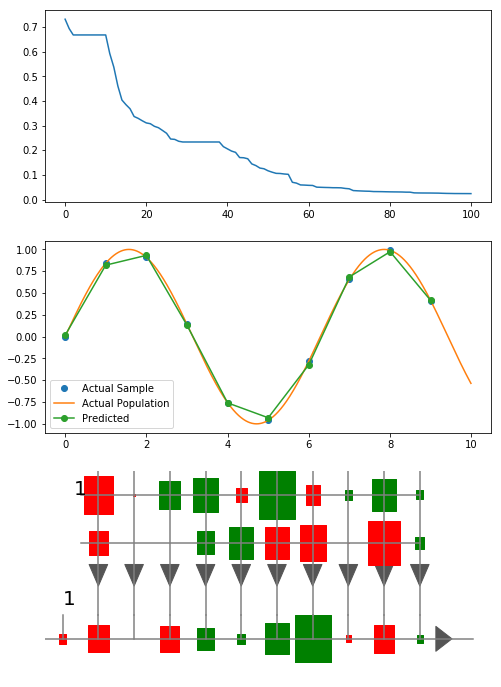

In [4]:
nnet = nn.NeuralNetwork(1, [10], 1)
nnet.train(X, T, 100, verbose=True)

plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(nnet.getErrors())

plt.subplot(3, 1, 2)
plt.plot(X, T, 'o', label='Actual Sample')
plt.plot(Xdense, np.sin(Xdense), label='Actual Population')
plt.plot(X, nnet.use(X), 'o-', label='Predicted')
plt.legend()

plt.subplot(3, 1, 3)
nnet.draw()

Test the activation function with different values to make sure it works.

In [5]:
nnet = nn.NeuralNetwork_relu(1, [10], 1)

In [6]:
test_values = [-2, -0.5, 0, [0, 0.5, -1], 2, np.array([-1, 2, -3])]
print([nnet.activation(s) for s in test_values])
print([nnet.activation_derivative(nnet.activation(s)) for s in test_values])

[0, 0.0, 0, array([0. , 0.5, 0. ]), 2, array([0, 2, 0])]
[array(0), array(0.), array(0), array([0., 1., 0.]), array(1), array([0, 1, 0])]


Looks like it works with both arrays, np.arrays, and scalars. Note that it returns `array(0)` instead of `0`, but that's not an issue since its still a scalar.

SCG: Iteration 10 fValue 0.4716899826954631 Scale 0.032768
SCG: Iteration 20 fValue 0.2410536433611583 Scale 0.032768
SCG: Iteration 30 fValue 0.23086479440810886 Scale 0.524288
SCG: Iteration 40 fValue 0.22190274262361878 Scale 1.048576
SCG: Iteration 50 fValue 0.21402379254685933 Scale 4.194304
SCG: Iteration 60 fValue 0.2117757796383153 Scale 0.524288
SCG: Iteration 70 fValue 0.2094825575544908 Scale 2.097152
SCG: Iteration 80 fValue 0.1846093459294394 Scale 0.004096
SCG: Iteration 90 fValue 0.17491091419425978 Scale 4e-06
SCG: Iteration 100 fValue 0.17469500557419243 Scale 3.90625e-09


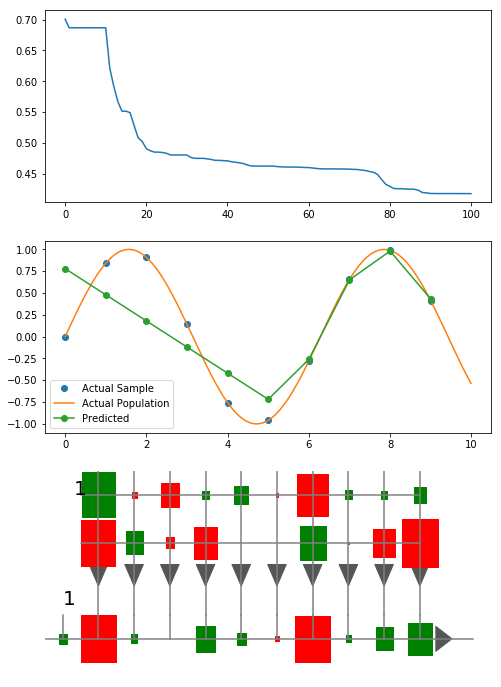

In [7]:
nnet.train(X, T, 100, verbose=True)

plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.plot(nnet.getErrors())

plt.subplot(3, 1, 2)
plt.plot(X, T, 'o', label='Actual Sample')
plt.plot(Xdense, np.sin(Xdense), label='Actual Population')
plt.plot(X, nnet.use(X), 'o-', label='Predicted')
plt.legend()

plt.subplot(3, 1, 3)
nnet.draw()

Looks like it works, but you can see that it doesn't fit as well. It seems like ReLU converges slower than atan since it can't converge to zero RMSE.

## Neural Network Performance with Different Hidden Layer Structures and Numbers of Training Iterations

### Example with Toy Data

Using your new ```NeuralNetwork``` class, you can compare the error obtained on a given data set by looping over various hidden layer structures.  Here is an example using the simple toy data from above.

In [8]:
nRows = X.shape[0]
rows = np.arange(nRows)
np.random.shuffle(rows)
nTrain = int(nRows * 0.8)
trainRows = rows[:nTrain]
testRows = rows[nTrain:]
Xtrain, Ttrain = X[trainRows, :], T[trainRows, :]
Xtest, Ttest = X[testRows, :], T[testRows, :]

In [9]:
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((8, 1), (8, 1), (2, 1), (2, 1))

In [10]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [11]:
import pandas as pd

In [12]:
def run_parameters(Xtrain, Ttrain, Xtest, Ttest, epochs_list, nh_list, verbose=True):

    n_inputs = Xtrain.shape[1]  # number of columns in X
    n_outputs = Ttrain.shape[1]  # number of columns in T
    
    results = pd.DataFrame(columns=['Epochs', 'Hidden Units', 'RMSE Train', 'RMSE Test'])
    for n_epochs in epochs_list:        
        for nh in nh_list:
            nnet = nn.NeuralNetwork(Xtrain.shape[1], nh, n_outputs)
            nnet.train(Xtrain, Ttrain, n_epochs)
            Ytrain = nnet.use(Xtrain)
            Ytest = nnet.use(Xtest)
            results.loc[len(results)] = [n_epochs, nh, rmse(Ytrain, Ttrain), 
                                         rmse(Ytest, Ttest)]
            if verbose:
                display(results.tail(1))  # not print
    return results

Build hidden layers to test. Given code:

In [13]:
hiddens = [[0]] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
hiddens

[[0],
 [1],
 [1, 1],
 [1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [5],
 [5, 5],
 [5, 5, 5],
 [5, 5, 5, 5],
 [5, 5, 5, 5, 5],
 [10],
 [10, 10],
 [10, 10, 10],
 [10, 10, 10, 10],
 [10, 10, 10, 10, 10],
 [20],
 [20, 20],
 [20, 20, 20],
 [20, 20, 20, 20],
 [20, 20, 20, 20, 20],
 [50],
 [50, 50],
 [50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50, 50]]

Generate results (also given):

In [14]:
results_hiddens = run_parameters(Xtrain, Ttrain, Xtest, Ttest, [500], hiddens, verbose=False)
results_hiddens

,Epochs,Hidden Units,RMSE Train,RMSE Test
0,500,[0],7.093257e-01,0.409787
1,500,[1],6.318188e-01,0.227362
2,500,"[1, 1]",6.672949e-01,0.376900
3,500,"[1, 1, 1]",6.318167e-01,0.223634
4,500,"[1, 1, 1, 1]",6.672949e-01,0.398029
5,500,"[1, 1, 1, 1, 1]",6.318167e-01,0.223634
6,500,[5],8.962676e-08,0.274164
7,500,"[5, 5]",7.110645e-09,0.092309
8,500,"[5, 5, 5]",5.528612e-09,0.051483
9,500,"[5, 5, 5, 5]",6.539726e-09,0.293420


I changed the following code to sort the Test RMSE before plotting so that it's easier to tell which performed best.

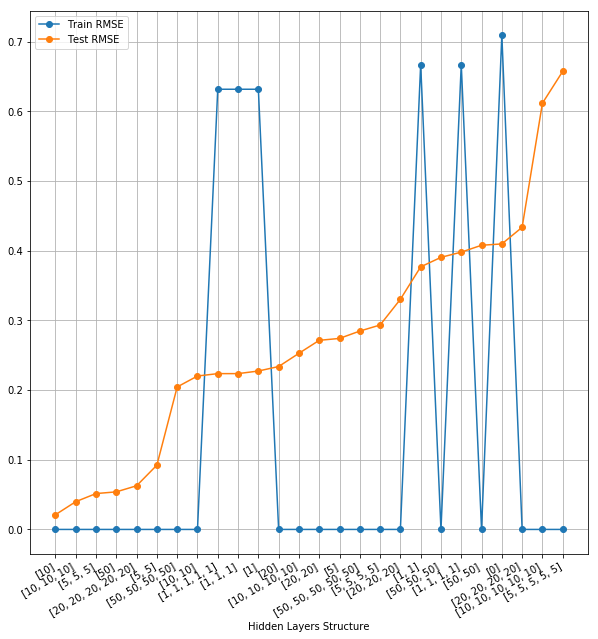

In [15]:
errors = np.array(results_hiddens[['RMSE Train', 'RMSE Test']])
sort_args = np.argsort(errors[:, 1]) # sort by test
plt.figure(figsize=(10, 10))
plt.plot(errors[sort_args, :], 'o-')
plt.legend(('Train RMSE', 'Test RMSE'))
hiddens_np = np.array(hiddens, dtype=object)
plt.xticks(range(errors[sort_args, :].shape[0]), hiddens_np[sort_args], rotation=30, horizontalalignment='right')
plt.xlabel('Hidden Layers Structure')
plt.grid(True)

Based off the graph, we see that the best structure is as follows:

In [16]:
print(hiddens[sort_args[0]])

[10]


In [17]:
best_structure = hiddens[sort_args[0]]
epochs = [1, 5, 10, 15, 20] + list(range(25, 1000, 25))
results_epochs = run_parameters(Xtrain, Ttrain, Xtest, Ttest, epochs, [best_structure], verbose=False)

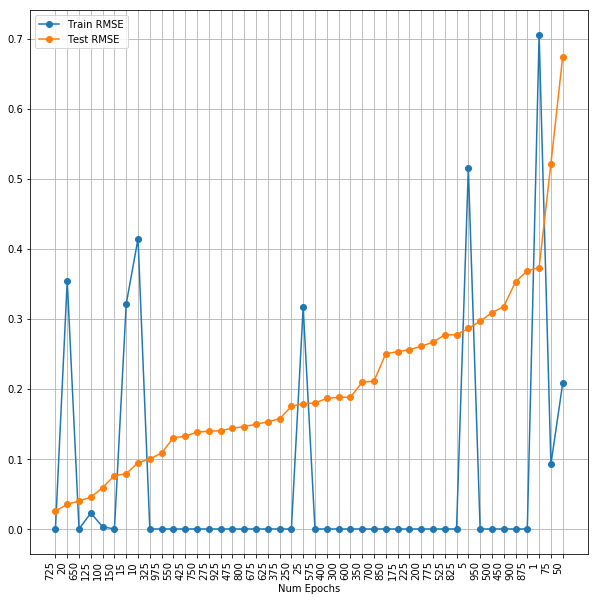

In [18]:
errors = np.array(results_epochs[['RMSE Train', 'RMSE Test']])
sort_args = np.argsort(errors[:, 1]) # sort by test
plt.figure(figsize=(10, 10))
plt.plot(errors[sort_args, :], 'o-')
plt.legend(('Train RMSE', 'Test RMSE'))
epochs_np = np.array(epochs, dtype=object)
plt.xticks(range(errors[sort_args, :].shape[0]), epochs_np[sort_args], rotation=90, horizontalalignment='right')
plt.xlabel('Num Epochs')
plt.grid(True)

I mutated the graph from above to plot a simliar result but with epochs. Now, we can see that the best epoch range is:

In [19]:
print('best structure:', best_structure)
print('best epoch:', epochs[sort_args[0]])
prev_best = best_structure, epochs[sort_args[0]]

best structure: [10]
best epoch: 725


Now, we can put all these steps in a function:

In [20]:
def run_parameters_cust_nn(Xtrain, Ttrain, Xtest, Ttest, epochs_list, nh_list, verbose=True, NN=None):
    
    if NN is None:
        NN = nn.NeuralNetwork
    
    n_inputs = Xtrain.shape[1]  # number of columns in X
    n_outputs = Ttrain.shape[1]  # number of columns in T
    
    results = pd.DataFrame(columns=['Epochs', 'Hidden Units', 'RMSE Train', 'RMSE Test'])
    for n_epochs in epochs_list:        
        for nh in nh_list:
            nnet = NN(Xtrain.shape[1], nh, n_outputs)
            nnet.train(Xtrain, Ttrain, n_epochs)
            Ytrain = nnet.use(Xtrain)
            Ytest = nnet.use(Xtest)
            results.loc[len(results)] = [n_epochs, nh, rmse(Ytrain, Ttrain), 
                                         rmse(Ytest, Ttest)]
            if verbose:
                pass # display(results.tail(1))  # not print
    return results

def split(X, T, split_ratio=.8):
    nRows = X.shape[0]
    rows = np.arange(nRows)
    np.random.shuffle(rows)
    nTrain = int(nRows * split_ratio)
    trainRows = rows[:nTrain]
    testRows = rows[nTrain:]
    Xtrain, Ttrain = X[trainRows, :], T[trainRows, :]
    Xtest, Ttest = X[testRows, :], T[testRows, :]
    return Xtrain, Ttrain, Xtest, Ttest

def find_best_struct(Xtrain, Ttrain, Xtest, Ttest, graph=True, epochs=500, NN=None):
    hiddens = [[0]] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
    results_hiddens = run_parameters_cust_nn(Xtrain, Ttrain, Xtest, Ttest, [epochs], hiddens, verbose=False, NN=NN)
    errors = np.array(results_hiddens[['RMSE Train', 'RMSE Test']])
    sort_args = np.argsort(errors[:, 1]) # sort by test
    hiddens = np.array(hiddens, dtype=object)
    if graph:
        plt.figure(figsize=(10, 10))
        plt.title('best network structure')
        plt.plot(errors[sort_args, :], 'o-')
        plt.legend(('Train RMSE', 'Test RMSE'))
        plt.xticks(range(errors[sort_args, :].shape[0]), hiddens[sort_args], rotation=30, horizontalalignment='right')
        plt.xlabel('Hidden Layers Structure')
        plt.grid(True)
    return hiddens[sort_args[0]]
        
def find_best_epochs(Xtrain, Ttrain, Xtest, Ttest, graph=True, best_structure=[1], NN=None):
    epochs = [1, 5, 10, 15, 20] + list(range(25, 1000, 25))
    results_epochs = run_parameters_cust_nn(Xtrain, Ttrain, Xtest, Ttest, epochs, [best_structure], verbose=False, NN=NN)
    errors = np.array(results_epochs[['RMSE Train', 'RMSE Test']])
    sort_args = np.argsort(errors[:, 1]) # sort by test
    epochs = np.array(epochs, dtype=object)
    if graph:
        plt.figure(figsize=(10, 10))
        plt.title('best number of epoch')
        plt.plot(errors[sort_args, :], 'o-')
        plt.legend(('Train RMSE', 'Test RMSE'))
        plt.xticks(range(errors[sort_args, :].shape[0]), epochs[sort_args], rotation=90, horizontalalignment='right')
        plt.xlabel('Num Epochs')
        plt.grid(True)
    return epochs[sort_args[0]]

def find_best_network(X, T, split_ratio=.8, NN=None):
    return find_best_network_already_split(*split(X, T, split_ratio=split_ratio), NN=NN)

def find_best_network_already_split(Xtrain, Ttrain, Xtest, Ttest, NN=None):
    if NN is None:
        NN = nn.NeuralNetwork
    best_structure = find_best_struct(Xtrain, Ttrain, Xtest, Ttest, NN=NN)
    epochs = find_best_epochs(Xtrain, Ttrain, Xtest, Ttest, best_structure=best_structure, NN=NN)
    return best_structure, epochs

This should return the same as above:

before: ([10], 725)
after: ([20, 20, 20, 20, 20], 450)


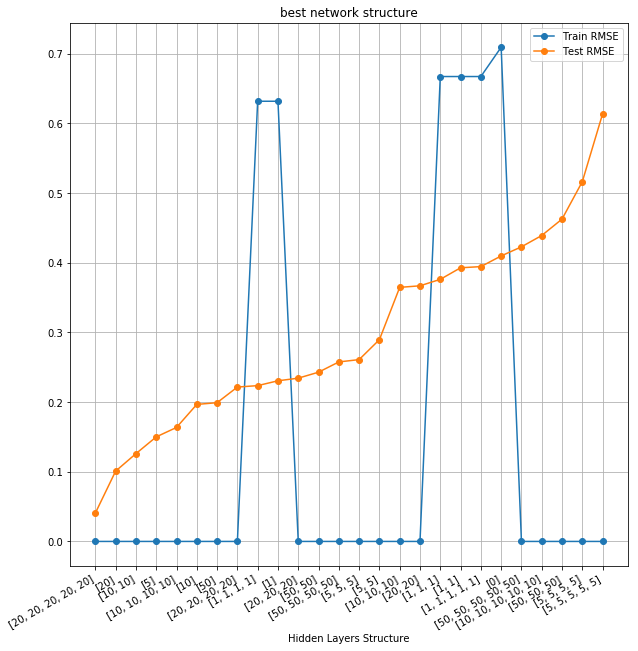

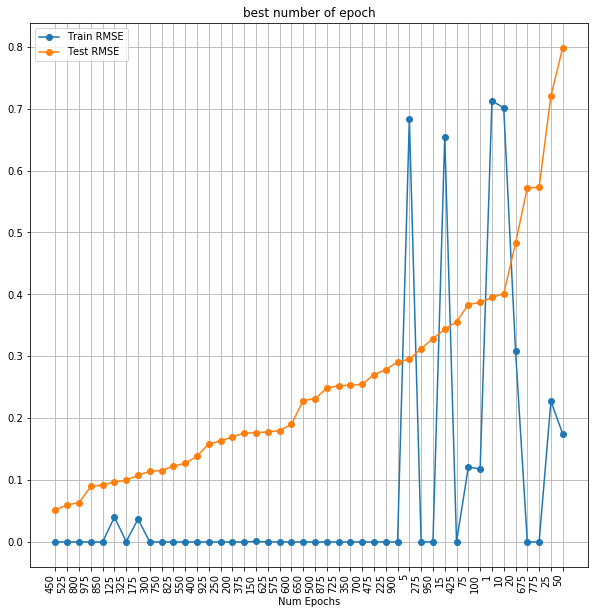

In [21]:
print('before:', prev_best)
print('after:', find_best_network_already_split(Xtrain, Ttrain, Xtest, Ttest))

But for some reason, it doesn't. This is likley due to randomly initialized weights. The results based on the graphs shows that what it's returning is what it found to be the bests, so at least, my algorithm works.

### Experiments with Automobile Data

Now, repeat the above steps with the automobile mpg data we have used before.  Set it up to use 

  * cylinders,
  * displacement,
  * weight,
  * acceleration,
  * year, and
  * origin
  
as input variables, and

  * mpg
  * horsepower
  
as output variables.

From Lecture 3, we do the following:

In [22]:
def missingIsNan(s):
    return np.nan if s == b'?' else float(s)
data = np.loadtxt('auto-mpg.data', usecols=range(8), converters={3: missingIsNan}) # parse file
bad_data_rows = np.any(np.isnan(data), axis=1) # find bad rows (rows means axis = 1)
data = data[np.logical_not(bad_data_rows)] # not bad rows to get good rows
print('Number of NANs in data:', np.sum(np.isnan(data))) # double check that we don't have any bad rows

Number of NANs in data: 0


In [23]:
from copy import copy 
names = [   
    'mpg',
    'cylinders',
    'displacement',
    'horsepower',
    'weight',
    'acceleration',
    'model year',
    'origin',
    #'car name', # removed since we removed that row of data
]
inputs = ['mpg', 'horsepower']
outputs = copy(names) # we want to modify outputs without changing names
for inp in inputs:
    outputs.remove(inp) # compliment set
inputs = [names.index(inp) for inp in inputs] # get index of inputs
outputs = [names.index(output) for output in outputs] # get index of outputs

We want to make sure it worked by comparing what was selected and what the data looks like.

In [24]:
df = pd.DataFrame(data, columns=names)
display(df[:5])
print('inputs', data[:5, inputs])
print('outputs', data[:5, outputs])

X = data[:, inputs]
T = data[:, outputs]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


inputs [[ 18. 130.]
 [ 15. 165.]
 [ 18. 150.]
 [ 16. 150.]
 [ 17. 140.]]
outputs [[8.000e+00 3.070e+02 3.504e+03 1.200e+01 7.000e+01 1.000e+00]
 [8.000e+00 3.500e+02 3.693e+03 1.150e+01 7.000e+01 1.000e+00]
 [8.000e+00 3.180e+02 3.436e+03 1.100e+01 7.000e+01 1.000e+00]
 [8.000e+00 3.040e+02 3.433e+03 1.200e+01 7.000e+01 1.000e+00]
 [8.000e+00 3.020e+02 3.449e+03 1.050e+01 7.000e+01 1.000e+00]]


We now have our data stored in X and T

Searching for parameters for atan..
For atan activation function, it found the best network to be [1, 1, 1] with 20 epochs.


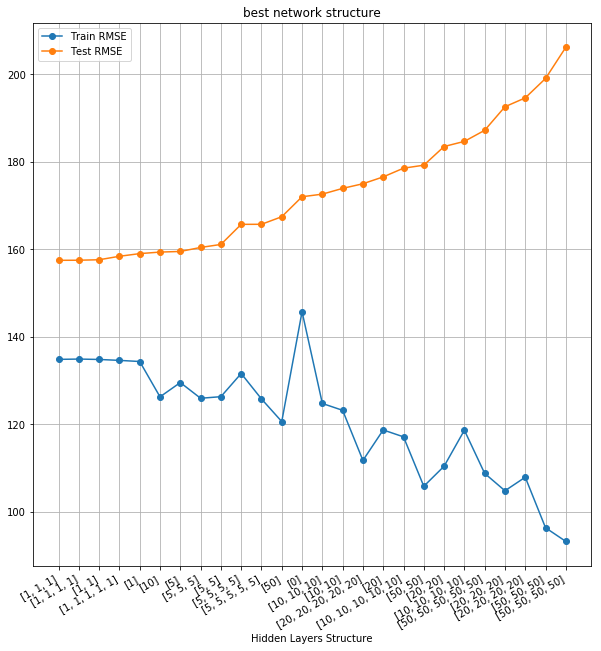

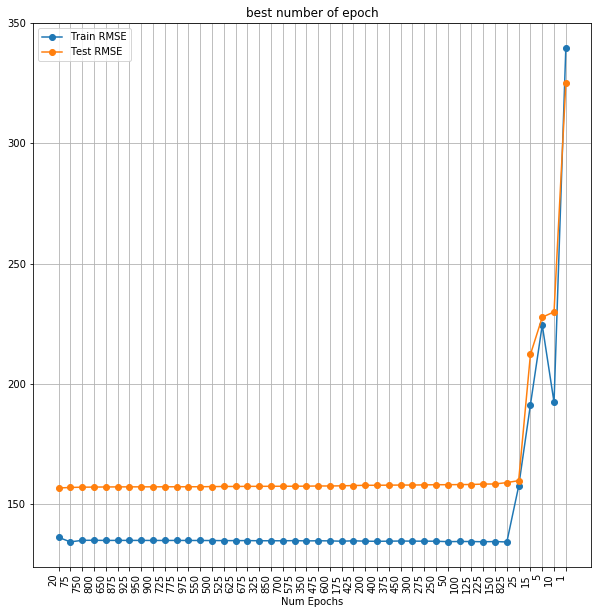

In [25]:
print('Searching for parameters for atan..')
best_car_atan = find_best_network(X, T)
print('For atan activation function, it found the best network to be {} with {} epochs.'.format(*best_car_atan))

It's interesting to see that the number of epochs was low, and the top structures had lots of layers but didn't need many nodes. This data must not be very complicated.

Searching for parameters for ReLU..
For ReLU activation function, it found the best network to be [5] with 20 epochs.


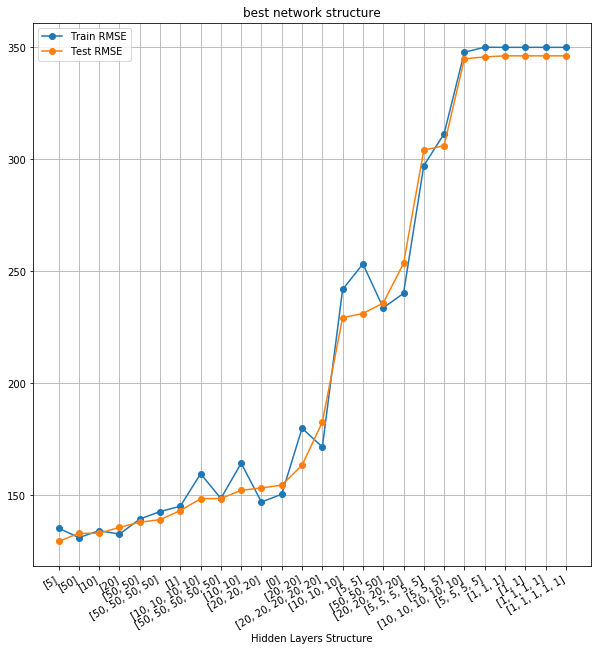

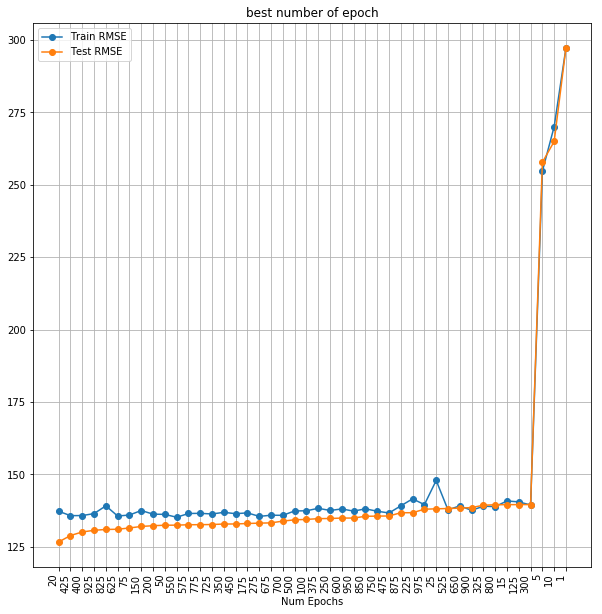

In [26]:
print('Searching for parameters for ReLU..')
best_car_relu = find_best_network(X, T, NN=nn.NeuralNetwork_relu)
print('For ReLU activation function, it found the best network to be {} with {} epochs.'.format(*best_car_relu))

This time, instead of lots of single node layers, it chose single layers of nodes. It just wanted a somewhat linear, linear combination of the input values to determine the output variables. Again, it didn't need many epochs to train it; although, following it are 400-800 range epochs, so maybe it does.

## Experiments with relu activation function

In [37]:
def run_parameters_act(Xtrain, Ttrain, Xtest, Ttest, activation_functions, epochs_list, nh_list, verbose=True):

    n_inputs = Xtrain.shape[1]  # number of columns in X
    n_outputs = Ttrain.shape[1]  # number of columns in T
    
    results = pd.DataFrame(columns=['Activation', 'Epochs', 'Hidden Units', 'RMSE Train', 'RMSE Test'])
    for n_epochs in epochs_list:        
        for nh in nh_list:
            for activation_function in activation_functions:
                if activation_function == 'tanh':
                    NN = nn.NeuralNetwork
                else:
                    NN = nn.NeuralNetwork_relu
                nnet = NN(Xtrain.shape[1], nh, n_outputs)
                nnet.train(Xtrain, Ttrain, n_epochs)
                Ytrain = nnet.use(Xtrain)
                Ytest = nnet.use(Xtest)
                results.loc[len(results)] = [activation_function, n_epochs, nh, rmse(Ytrain, Ttrain), 
                                             rmse(Ytest, Ttest)]
                if verbose:
                    display(results.tail(1))  # not print
    return results

In [40]:
XTsplit = split(X, T) # machine mpg data
results = run_parameters_act(*XTsplit, ['tanh', 'relu'], epochs[::3], hiddens, verbose=True)

,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
0,tanh,1,[0],91.310906,77.631847


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
1,relu,1,[0],94.161154,62.875512


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
2,tanh,1,[1],162.1227,69.794451


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
3,relu,1,[1],171.419881,79.028075


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
4,tanh,1,"[1, 1]",168.769001,76.481054


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
5,relu,1,"[1, 1]",178.676469,110.449781


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
6,tanh,1,"[1, 1, 1]",171.927504,81.441651


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
7,relu,1,"[1, 1, 1]",173.543507,88.398189


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
8,tanh,1,"[1, 1, 1, 1]",171.848142,80.365006


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
9,relu,1,"[1, 1, 1, 1]",171.844115,78.816573


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
10,tanh,1,"[1, 1, 1, 1, 1]",171.837251,78.813095


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
11,relu,1,"[1, 1, 1, 1, 1]",171.929964,77.378951


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
12,tanh,1,[5],141.519645,110.079646


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
13,relu,1,[5],164.607896,71.135849


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
14,tanh,1,"[5, 5]",163.616637,63.956759


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
15,relu,1,"[5, 5]",173.763053,99.601056


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
16,tanh,1,"[5, 5, 5]",162.984002,66.909833


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
17,relu,1,"[5, 5, 5]",171.803836,79.644838


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
18,tanh,1,"[5, 5, 5, 5]",171.924058,84.995351


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
19,relu,1,"[5, 5, 5, 5]",185.936168,109.898387


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
20,tanh,1,"[5, 5, 5, 5, 5]",168.746341,80.582157


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
21,relu,1,"[5, 5, 5, 5, 5]",171.794817,78.874415


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
22,tanh,1,[10],118.186039,31.635632


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
23,relu,1,[10],87.345946,51.040315


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
24,tanh,1,"[10, 10]",131.881759,99.742271


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
25,relu,1,"[10, 10]",167.825319,68.992041


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
26,tanh,1,"[10, 10, 10]",156.649953,82.432343


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
27,relu,1,"[10, 10, 10]",172.36668,69.32051


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
28,tanh,1,"[10, 10, 10, 10]",166.504589,68.260145


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
29,relu,1,"[10, 10, 10, 10]",170.757398,76.820401


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
30,tanh,1,"[10, 10, 10, 10, 10]",171.242533,74.575918


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
31,relu,1,"[10, 10, 10, 10, 10]",172.438362,89.693358


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
32,tanh,1,[20],99.004331,60.439808


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
33,relu,1,[20],116.452143,110.426894


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
34,tanh,1,"[20, 20]",135.063066,35.500307


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
35,relu,1,"[20, 20]",165.873149,69.022985


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
36,tanh,1,"[20, 20, 20]",156.08092,79.07994


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
37,relu,1,"[20, 20, 20]",173.471353,73.826738


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
38,tanh,1,"[20, 20, 20, 20]",160.409848,59.177329


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
39,relu,1,"[20, 20, 20, 20]",177.011367,83.984245


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
40,tanh,1,"[20, 20, 20, 20, 20]",167.653272,75.83733


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
41,relu,1,"[20, 20, 20, 20, 20]",171.934953,80.230226


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
42,tanh,1,[50],103.162494,63.00682


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
43,relu,1,[50],79.01337,64.85963


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
44,tanh,1,"[50, 50]",113.073853,48.04152


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
45,relu,1,"[50, 50]",108.763427,98.324074


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
46,tanh,1,"[50, 50, 50]",131.455636,109.072435


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
47,relu,1,"[50, 50, 50]",147.376967,58.531385


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
48,tanh,1,"[50, 50, 50, 50]",138.003957,40.475273


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
49,relu,1,"[50, 50, 50, 50]",173.336273,83.559877


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
50,tanh,1,"[50, 50, 50, 50, 50]",169.894735,77.800968


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
51,relu,1,"[50, 50, 50, 50, 50]",171.707293,78.233567


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
52,tanh,15,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
53,relu,15,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
54,tanh,15,[1],68.179684,27.506112


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
55,relu,15,[1],89.918295,53.441239


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
56,tanh,15,"[1, 1]",87.260925,44.552747


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
57,relu,15,"[1, 1]",153.626226,66.803357


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
58,tanh,15,"[1, 1, 1]",97.045383,57.834316


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
59,relu,15,"[1, 1, 1]",171.844115,78.816648


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
60,tanh,15,"[1, 1, 1, 1]",171.572367,80.225126


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
61,relu,15,"[1, 1, 1, 1]",171.844115,78.816599


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
62,tanh,15,"[1, 1, 1, 1, 1]",114.463328,53.177801


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
63,relu,15,"[1, 1, 1, 1, 1]",171.844115,78.816548


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
64,tanh,15,[5],83.407836,52.588286


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
65,relu,15,[5],45.060935,39.099912


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
66,tanh,15,"[5, 5]",52.185215,33.063008


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
67,relu,15,"[5, 5]",161.162764,78.404225


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
68,tanh,15,"[5, 5, 5]",113.572355,51.869423


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
69,relu,15,"[5, 5, 5]",115.569635,111.903151


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
70,tanh,15,"[5, 5, 5, 5]",77.537543,36.176831


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
71,relu,15,"[5, 5, 5, 5]",172.013258,75.530435


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
72,tanh,15,"[5, 5, 5, 5, 5]",69.111623,50.138626


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
73,relu,15,"[5, 5, 5, 5, 5]",171.855995,78.169509


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
74,tanh,15,[10],50.716674,34.240245


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
75,relu,15,[10],42.81348,32.954605


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
76,tanh,15,"[10, 10]",89.065806,51.573485


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
77,relu,15,"[10, 10]",170.295578,91.831312


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
78,tanh,15,"[10, 10, 10]",99.526012,50.791057


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
79,relu,15,"[10, 10, 10]",171.595781,79.806474


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
80,tanh,15,"[10, 10, 10, 10]",77.612264,57.948012


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
81,relu,15,"[10, 10, 10, 10]",152.26375,55.129146


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
82,tanh,15,"[10, 10, 10, 10, 10]",72.283569,38.083904


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
83,relu,15,"[10, 10, 10, 10, 10]",170.950867,81.421023


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
84,tanh,15,[20],52.80157,44.016212


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
85,relu,15,[20],37.191718,32.396679


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
86,tanh,15,"[20, 20]",48.899014,33.175979


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
87,relu,15,"[20, 20]",90.687531,53.136011


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
88,tanh,15,"[20, 20, 20]",94.171365,59.679426


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
89,relu,15,"[20, 20, 20]",65.9708,52.329502


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
90,tanh,15,"[20, 20, 20, 20]",52.438918,40.332114


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
91,relu,15,"[20, 20, 20, 20]",110.072469,45.968714


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
92,tanh,15,"[20, 20, 20, 20, 20]",64.79939,38.302281


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
93,relu,15,"[20, 20, 20, 20, 20]",70.702654,55.301046


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
94,tanh,15,[50],39.690198,34.738233


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
95,relu,15,[50],33.758428,22.933687


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
96,tanh,15,"[50, 50]",41.326412,38.153355


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
97,relu,15,"[50, 50]",101.853682,92.673319


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
98,tanh,15,"[50, 50, 50]",51.037477,42.165943


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
99,relu,15,"[50, 50, 50]",127.738962,89.320144


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
100,tanh,15,"[50, 50, 50, 50]",63.63697,36.71254


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
101,relu,15,"[50, 50, 50, 50]",159.684746,85.544592


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
102,tanh,15,"[50, 50, 50, 50, 50]",72.389655,66.738621


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
103,relu,15,"[50, 50, 50, 50, 50]",86.51124,60.670918


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
104,tanh,50,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
105,relu,50,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
106,tanh,50,[1],39.733021,27.903345


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
107,relu,50,[1],67.734457,43.114808


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
108,tanh,50,"[1, 1]",40.345822,27.344625


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
109,relu,50,"[1, 1]",96.132257,63.174129


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
110,tanh,50,"[1, 1, 1]",52.813048,35.574009


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
111,relu,50,"[1, 1, 1]",126.238091,53.725139


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
112,tanh,50,"[1, 1, 1, 1]",62.766306,40.554123


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
113,relu,50,"[1, 1, 1, 1]",171.844115,78.816647


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
114,tanh,50,"[1, 1, 1, 1, 1]",57.89411,29.822013


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
115,relu,50,"[1, 1, 1, 1, 1]",171.844115,78.816455


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
116,tanh,50,[5],25.434701,28.020403


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
117,relu,50,[5],35.135435,26.765548


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
118,tanh,50,"[5, 5]",27.280636,25.968677


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
119,relu,50,"[5, 5]",155.656246,92.837811


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
120,tanh,50,"[5, 5, 5]",26.765112,31.599513


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
121,relu,50,"[5, 5, 5]",170.19693,86.446594


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
122,tanh,50,"[5, 5, 5, 5]",29.006525,34.797527


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
123,relu,50,"[5, 5, 5, 5]",163.015476,66.572622


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
124,tanh,50,"[5, 5, 5, 5, 5]",30.480955,32.543909


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
125,relu,50,"[5, 5, 5, 5, 5]",171.862027,78.720336


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
126,tanh,50,[10],25.878385,35.923765


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
127,relu,50,[10],28.598935,25.96909


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
128,tanh,50,"[10, 10]",24.500029,28.402148


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
129,relu,50,"[10, 10]",155.476234,79.311112


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
130,tanh,50,"[10, 10, 10]",25.222275,33.433473


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
131,relu,50,"[10, 10, 10]",167.089056,102.254561


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
132,tanh,50,"[10, 10, 10, 10]",30.274797,36.111855


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
133,relu,50,"[10, 10, 10, 10]",133.15589,45.532536


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
134,tanh,50,"[10, 10, 10, 10, 10]",27.317503,29.474502


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
135,relu,50,"[10, 10, 10, 10, 10]",171.341781,79.019715


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
136,tanh,50,[20],22.395814,33.302542


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
137,relu,50,[20],26.716378,26.298769


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
138,tanh,50,"[20, 20]",24.610124,34.082035


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
139,relu,50,"[20, 20]",59.085836,45.362493


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
140,tanh,50,"[20, 20, 20]",25.670143,31.968596


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
141,relu,50,"[20, 20, 20]",108.048131,90.955003


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
142,tanh,50,"[20, 20, 20, 20]",25.152862,30.574306


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
143,relu,50,"[20, 20, 20, 20]",154.832196,69.095269


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
144,tanh,50,"[20, 20, 20, 20, 20]",26.552245,29.425304


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
145,relu,50,"[20, 20, 20, 20, 20]",73.077757,62.923634


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
146,tanh,50,[50],21.174528,30.307864


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
147,relu,50,[50],18.780827,28.933559


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
148,tanh,50,"[50, 50]",23.376742,29.642194


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
149,relu,50,"[50, 50]",146.495362,147.928337


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
150,tanh,50,"[50, 50, 50]",25.972645,34.220335


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
151,relu,50,"[50, 50, 50]",145.182398,126.402261


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
152,tanh,50,"[50, 50, 50, 50]",25.98013,32.328766


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
153,relu,50,"[50, 50, 50, 50]",132.592906,69.558974


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
154,tanh,50,"[50, 50, 50, 50, 50]",25.915247,32.78669


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
155,relu,50,"[50, 50, 50, 50, 50]",125.082259,85.052102


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
156,tanh,125,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
157,relu,125,[0],61.917251,49.178302


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
158,tanh,125,[1],38.723322,27.269555


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
159,relu,125,[1],171.844115,78.816578


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
160,tanh,125,"[1, 1]",41.079101,27.15324


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
161,relu,125,"[1, 1]",129.325019,95.47752


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
162,tanh,125,"[1, 1, 1]",41.124177,26.840006


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
163,relu,125,"[1, 1, 1]",171.844115,78.816582


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
164,tanh,125,"[1, 1, 1, 1]",43.507184,26.22422


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
165,relu,125,"[1, 1, 1, 1]",171.549184,75.499463


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
166,tanh,125,"[1, 1, 1, 1, 1]",41.818044,26.167345


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
167,relu,125,"[1, 1, 1, 1, 1]",171.844115,78.816733


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
168,tanh,125,[5],22.712185,36.826215


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
169,relu,125,[5],34.295714,27.974454


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
170,tanh,125,"[5, 5]",23.275743,29.203233


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
171,relu,125,"[5, 5]",121.053124,109.434934


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
172,tanh,125,"[5, 5, 5]",24.448345,28.460253


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
173,relu,125,"[5, 5, 5]",106.67362,58.6502


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
174,tanh,125,"[5, 5, 5, 5]",26.126518,30.643012


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
175,relu,125,"[5, 5, 5, 5]",171.93544,79.388203


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
176,tanh,125,"[5, 5, 5, 5, 5]",25.196605,29.858062


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
177,relu,125,"[5, 5, 5, 5, 5]",171.87427,78.71746


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
178,tanh,125,[10],18.903288,35.171776


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
179,relu,125,[10],25.143602,25.405323


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
180,tanh,125,"[10, 10]",19.587591,34.028931


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
181,relu,125,"[10, 10]",136.153049,51.400986


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
182,tanh,125,"[10, 10, 10]",22.184365,31.938041


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
183,relu,125,"[10, 10, 10]",169.780468,148.203831


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
184,tanh,125,"[10, 10, 10, 10]",24.769139,29.161441


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
185,relu,125,"[10, 10, 10, 10]",138.8783,60.430673


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
186,tanh,125,"[10, 10, 10, 10, 10]",24.193432,27.466648


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
187,relu,125,"[10, 10, 10, 10, 10]",171.875132,78.803098


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
188,tanh,125,[20],17.450905,32.262757


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
189,relu,125,[20],22.242179,27.750463


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
190,tanh,125,"[20, 20]",17.846189,34.127721


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
191,relu,125,"[20, 20]",122.5221,55.574632


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
192,tanh,125,"[20, 20, 20]",21.134309,26.608949


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
193,relu,125,"[20, 20, 20]",141.158532,58.999154


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
194,tanh,125,"[20, 20, 20, 20]",23.501166,25.121266


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
195,relu,125,"[20, 20, 20, 20]",129.02967,109.755571


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
196,tanh,125,"[20, 20, 20, 20, 20]",23.451308,26.670339


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
197,relu,125,"[20, 20, 20, 20, 20]",163.905066,134.984918


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
198,tanh,125,[50],17.228232,30.655019


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
199,relu,125,[50],16.331801,26.147682


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
200,tanh,125,"[50, 50]",18.021245,34.602316


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
201,relu,125,"[50, 50]",61.708525,39.98853


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
202,tanh,125,"[50, 50, 50]",18.264501,29.273868


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
203,relu,125,"[50, 50, 50]",158.802601,67.957049


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
204,tanh,125,"[50, 50, 50, 50]",22.463755,29.324547


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
205,relu,125,"[50, 50, 50, 50]",84.322542,71.77412


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
206,tanh,125,"[50, 50, 50, 50, 50]",22.874485,29.369863


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
207,relu,125,"[50, 50, 50, 50, 50]",155.277428,83.66954


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
208,tanh,200,[0],61.917251,49.178302


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
209,relu,200,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
210,tanh,200,[1],38.30906,27.375294


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
211,relu,200,[1],48.643445,39.130964


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
212,tanh,200,"[1, 1]",38.940475,27.193018


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
213,relu,200,"[1, 1]",88.90716,74.691332


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
214,tanh,200,"[1, 1, 1]",39.736059,26.991861


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
215,relu,200,"[1, 1, 1]",171.844115,78.816523


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
216,tanh,200,"[1, 1, 1, 1]",39.785668,26.879052


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
217,relu,200,"[1, 1, 1, 1]",171.844115,78.816588


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
218,tanh,200,"[1, 1, 1, 1, 1]",41.091512,26.617461


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
219,relu,200,"[1, 1, 1, 1, 1]",171.844115,78.816595


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
220,tanh,200,[5],21.457551,29.320614


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
221,relu,200,[5],32.366847,26.844314


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
222,tanh,200,"[5, 5]",21.286104,35.00229


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
223,relu,200,"[5, 5]",162.405465,93.661109


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
224,tanh,200,"[5, 5, 5]",20.828781,28.332085


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
225,relu,200,"[5, 5, 5]",169.554558,76.809692


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
226,tanh,200,"[5, 5, 5, 5]",23.254784,35.996901


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
227,relu,200,"[5, 5, 5, 5]",171.533605,79.862522


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
228,tanh,200,"[5, 5, 5, 5, 5]",25.353628,28.045218


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
229,relu,200,"[5, 5, 5, 5, 5]",157.69038,59.562544


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
230,tanh,200,[10],19.012578,36.706198


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
231,relu,200,[10],25.354922,24.61899


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
232,tanh,200,"[10, 10]",17.250769,27.378282


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
233,relu,200,"[10, 10]",103.963711,71.318766


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
234,tanh,200,"[10, 10, 10]",17.785604,28.528707


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
235,relu,200,"[10, 10, 10]",68.996422,59.867405


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
236,tanh,200,"[10, 10, 10, 10]",21.618364,24.435363


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
237,relu,200,"[10, 10, 10, 10]",169.197163,70.627788


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
238,tanh,200,"[10, 10, 10, 10, 10]",23.194233,32.470573


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
239,relu,200,"[10, 10, 10, 10, 10]",171.639927,84.354273


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
240,tanh,200,[20],16.851486,26.494578


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
241,relu,200,[20],21.466822,26.92938


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
242,tanh,200,"[20, 20]",17.975753,32.259506


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
243,relu,200,"[20, 20]",98.326945,77.353372


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
244,tanh,200,"[20, 20, 20]",18.100084,30.516903


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
245,relu,200,"[20, 20, 20]",174.510331,78.509884


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
246,tanh,200,"[20, 20, 20, 20]",17.998114,29.151745


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
247,relu,200,"[20, 20, 20, 20]",167.312092,75.494085


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
248,tanh,200,"[20, 20, 20, 20, 20]",18.666757,25.799785


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
249,relu,200,"[20, 20, 20, 20, 20]",170.303151,78.219007


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
250,tanh,200,[50],16.64186,30.389505


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
251,relu,200,[50],13.322911,28.277711


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
252,tanh,200,"[50, 50]",17.084852,37.182314


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
253,relu,200,"[50, 50]",73.918162,45.335453


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
254,tanh,200,"[50, 50, 50]",17.768114,28.612281


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
255,relu,200,"[50, 50, 50]",147.525499,77.767331


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
256,tanh,200,"[50, 50, 50, 50]",18.267285,27.632313


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
257,relu,200,"[50, 50, 50, 50]",168.983662,109.524274


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
258,tanh,200,"[50, 50, 50, 50, 50]",19.262297,27.534277


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
259,relu,200,"[50, 50, 50, 50, 50]",170.666532,152.464921


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
260,tanh,275,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
261,relu,275,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
262,tanh,275,[1],38.28483,27.403536


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
263,relu,275,[1],71.4169,42.264888


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
264,tanh,275,"[1, 1]",38.348118,27.280515


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
265,relu,275,"[1, 1]",96.49873,31.49294


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
266,tanh,275,"[1, 1, 1]",38.887753,26.84409


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
267,relu,275,"[1, 1, 1]",171.844115,78.816615


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
268,tanh,275,"[1, 1, 1, 1]",39.412008,26.597399


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
269,relu,275,"[1, 1, 1, 1]",171.844115,78.816627


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
270,tanh,275,"[1, 1, 1, 1, 1]",41.21309,26.565021


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
271,relu,275,"[1, 1, 1, 1, 1]",171.851851,79.595948


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
272,tanh,275,[5],20.188611,31.253132


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
273,relu,275,[5],34.935614,28.534766


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
274,tanh,275,"[5, 5]",18.791216,28.394591


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
275,relu,275,"[5, 5]",117.605547,119.640412


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
276,tanh,275,"[5, 5, 5]",22.936954,29.990943


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
277,relu,275,"[5, 5, 5]",145.858935,69.993303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
278,tanh,275,"[5, 5, 5, 5]",24.299775,27.643332


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
279,relu,275,"[5, 5, 5, 5]",149.46377,60.751894


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
280,tanh,275,"[5, 5, 5, 5, 5]",24.697735,27.555389


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
281,relu,275,"[5, 5, 5, 5, 5]",171.844115,78.816568


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
282,tanh,275,[10],17.132115,27.845121


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
283,relu,275,[10],27.811358,28.342383


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
284,tanh,275,"[10, 10]",16.132595,35.207125


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
285,relu,275,"[10, 10]",90.800707,31.54425


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
286,tanh,275,"[10, 10, 10]",16.949232,35.128042


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
287,relu,275,"[10, 10, 10]",166.949506,78.014208


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
288,tanh,275,"[10, 10, 10, 10]",19.641433,25.361155


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
289,relu,275,"[10, 10, 10, 10]",100.494641,80.638918


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
290,tanh,275,"[10, 10, 10, 10, 10]",21.466304,33.179328


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
291,relu,275,"[10, 10, 10, 10, 10]",170.061297,71.275998


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
292,tanh,275,[20],15.90412,35.154256


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
293,relu,275,[20],16.876248,32.342769


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
294,tanh,275,"[20, 20]",15.393644,29.078976


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
295,relu,275,"[20, 20]",107.767467,68.214296


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
296,tanh,275,"[20, 20, 20]",16.061565,29.625492


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
297,relu,275,"[20, 20, 20]",132.835562,70.512831


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
298,tanh,275,"[20, 20, 20, 20]",16.306832,31.136026


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
299,relu,275,"[20, 20, 20, 20]",171.519587,67.918423


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
300,tanh,275,"[20, 20, 20, 20, 20]",18.489464,22.726057


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
301,relu,275,"[20, 20, 20, 20, 20]",166.142362,73.965672


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
302,tanh,275,[50],15.35507,29.431035


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
303,relu,275,[50],13.291227,29.750925


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
304,tanh,275,"[50, 50]",16.274215,31.466075


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
305,relu,275,"[50, 50]",57.063286,34.993618


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
306,tanh,275,"[50, 50, 50]",15.996306,30.897843


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
307,relu,275,"[50, 50, 50]",103.185445,62.069914


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
308,tanh,275,"[50, 50, 50, 50]",17.657265,28.657246


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
309,relu,275,"[50, 50, 50, 50]",153.055547,85.417222


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
310,tanh,275,"[50, 50, 50, 50, 50]",17.554769,29.660343


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
311,relu,275,"[50, 50, 50, 50, 50]",75.106648,73.329137


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
312,tanh,350,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
313,relu,350,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
314,tanh,350,[1],38.300113,27.380786


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
315,relu,350,[1],48.237948,43.040297


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
316,tanh,350,"[1, 1]",38.315577,27.346376


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
317,relu,350,"[1, 1]",171.844115,78.816615


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
318,tanh,350,"[1, 1, 1]",52.998821,33.049263


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
319,relu,350,"[1, 1, 1]",169.096946,74.34573


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
320,tanh,350,"[1, 1, 1, 1]",39.191192,26.498756


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
321,relu,350,"[1, 1, 1, 1]",171.844115,78.816597


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
322,tanh,350,"[1, 1, 1, 1, 1]",41.718117,27.031809


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
323,relu,350,"[1, 1, 1, 1, 1]",171.860742,80.268459


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
324,tanh,350,[5],20.666117,31.769043


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
325,relu,350,[5],33.430955,33.417625


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
326,tanh,350,"[5, 5]",20.493119,24.96769


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
327,relu,350,"[5, 5]",159.171331,94.507212


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
328,tanh,350,"[5, 5, 5]",18.862741,25.508238


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
329,relu,350,"[5, 5, 5]",111.817101,106.107922


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
330,tanh,350,"[5, 5, 5, 5]",17.634434,29.196016


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
331,relu,350,"[5, 5, 5, 5]",172.041358,75.743861


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
332,tanh,350,"[5, 5, 5, 5, 5]",22.998783,34.285096


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
333,relu,350,"[5, 5, 5, 5, 5]",171.842928,79.369845


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
334,tanh,350,[10],16.548242,31.964854


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
335,relu,350,[10],28.02968,26.109104


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
336,tanh,350,"[10, 10]",15.076173,30.043526


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
337,relu,350,"[10, 10]",93.816224,67.347767


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
338,tanh,350,"[10, 10, 10]",16.079568,32.733378


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
339,relu,350,"[10, 10, 10]",170.889659,146.686089


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
340,tanh,350,"[10, 10, 10, 10]",17.870302,32.310008


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
341,relu,350,"[10, 10, 10, 10]",171.813775,75.278182


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
342,tanh,350,"[10, 10, 10, 10, 10]",18.217485,24.674165


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
343,relu,350,"[10, 10, 10, 10, 10]",161.833177,69.260092


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
344,tanh,350,[20],15.288027,30.476073


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
345,relu,350,[20],18.43481,30.01172


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
346,tanh,350,"[20, 20]",15.437352,32.851454


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
347,relu,350,"[20, 20]",132.705923,66.473804


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
348,tanh,350,"[20, 20, 20]",16.194872,22.620245


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
349,relu,350,"[20, 20, 20]",53.362879,36.611734


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
350,tanh,350,"[20, 20, 20, 20]",15.918186,30.11067


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
351,relu,350,"[20, 20, 20, 20]",103.518177,54.914982


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
352,tanh,350,"[20, 20, 20, 20, 20]",17.727982,32.949116


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
353,relu,350,"[20, 20, 20, 20, 20]",125.892892,122.264584


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
354,tanh,350,[50],14.58073,35.136867


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
355,relu,350,[50],13.707578,26.06755


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
356,tanh,350,"[50, 50]",14.980054,33.103811


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
357,relu,350,"[50, 50]",78.129083,50.400489


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
358,tanh,350,"[50, 50, 50]",15.239616,34.014451


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
359,relu,350,"[50, 50, 50]",68.525438,46.146196


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
360,tanh,350,"[50, 50, 50, 50]",16.716704,27.085419


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
361,relu,350,"[50, 50, 50, 50]",147.043747,81.573219


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
362,tanh,350,"[50, 50, 50, 50, 50]",17.501215,29.445189


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
363,relu,350,"[50, 50, 50, 50, 50]",84.426307,42.067637


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
364,tanh,425,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
365,relu,425,[0],61.917251,49.178304


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
366,tanh,425,[1],38.060982,27.585523


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
367,relu,425,[1],48.237948,43.04029


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
368,tanh,425,"[1, 1]",38.253455,27.568225


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
369,relu,425,"[1, 1]",171.844115,78.816606


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
370,tanh,425,"[1, 1, 1]",38.505914,27.204576


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
371,relu,425,"[1, 1, 1]",171.845729,78.592335


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
372,tanh,425,"[1, 1, 1, 1]",38.670936,27.036691


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
373,relu,425,"[1, 1, 1, 1]",171.844115,78.816482


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
374,tanh,425,"[1, 1, 1, 1, 1]",39.415171,26.672804


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
375,relu,425,"[1, 1, 1, 1, 1]",171.844115,78.816582


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
376,tanh,425,[5],21.632921,30.412611


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
377,relu,425,[5],32.755913,29.049435


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
378,tanh,425,"[5, 5]",18.427306,24.252357


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
379,relu,425,"[5, 5]",127.189953,81.632271


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
380,tanh,425,"[5, 5, 5]",18.185098,30.787281


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
381,relu,425,"[5, 5, 5]",167.288379,80.471135


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
382,tanh,425,"[5, 5, 5, 5]",17.830924,36.649849


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
383,relu,425,"[5, 5, 5, 5]",119.243884,35.80572


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
384,tanh,425,"[5, 5, 5, 5, 5]",21.434614,29.252807


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
385,relu,425,"[5, 5, 5, 5, 5]",171.833514,78.50627


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
386,tanh,425,[10],16.428903,33.289043


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
387,relu,425,[10],26.856031,29.181988


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
388,tanh,425,"[10, 10]",15.251053,25.999391


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
389,relu,425,"[10, 10]",132.170436,84.806048


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
390,tanh,425,"[10, 10, 10]",15.445559,22.307993


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
391,relu,425,"[10, 10, 10]",88.442768,69.60196


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
392,tanh,425,"[10, 10, 10, 10]",15.96812,29.942278


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
393,relu,425,"[10, 10, 10, 10]",162.888054,70.891161


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
394,tanh,425,"[10, 10, 10, 10, 10]",16.111868,33.105295


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
395,relu,425,"[10, 10, 10, 10, 10]",94.848961,72.328671


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
396,tanh,425,[20],15.017839,29.138845


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
397,relu,425,[20],15.459688,28.668404


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
398,tanh,425,"[20, 20]",14.799061,28.154378


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
399,relu,425,"[20, 20]",58.105499,39.193177


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
400,tanh,425,"[20, 20, 20]",14.773412,30.735405


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
401,relu,425,"[20, 20, 20]",120.578973,58.604605


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
402,tanh,425,"[20, 20, 20, 20]",15.00083,28.033221


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
403,relu,425,"[20, 20, 20, 20]",168.95179,77.203907


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
404,tanh,425,"[20, 20, 20, 20, 20]",15.538073,25.147885


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
405,relu,425,"[20, 20, 20, 20, 20]",124.313113,51.86247


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
406,tanh,425,[50],14.462487,28.627782


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
407,relu,425,[50],13.304041,28.459089


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
408,tanh,425,"[50, 50]",14.722552,35.214261


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
409,relu,425,"[50, 50]",72.106759,52.798109


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
410,tanh,425,"[50, 50, 50]",15.066788,26.994165


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
411,relu,425,"[50, 50, 50]",98.269449,63.972391


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
412,tanh,425,"[50, 50, 50, 50]",16.088455,36.579073


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
413,relu,425,"[50, 50, 50, 50]",164.269863,92.317446


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
414,tanh,425,"[50, 50, 50, 50, 50]",15.782972,30.071194


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
415,relu,425,"[50, 50, 50, 50, 50]",60.331068,56.853298


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
416,tanh,500,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
417,relu,500,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
418,tanh,500,[1],38.12873,27.497769


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
419,relu,500,[1],75.25389,38.627646


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
420,tanh,500,"[1, 1]",38.330852,27.341726


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
421,relu,500,"[1, 1]",165.577617,75.548991


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
422,tanh,500,"[1, 1, 1]",38.338602,27.394505


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
423,relu,500,"[1, 1, 1]",163.241851,70.123574


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
424,tanh,500,"[1, 1, 1, 1]",38.888746,26.972227


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
425,relu,500,"[1, 1, 1, 1]",171.844115,78.816553


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
426,tanh,500,"[1, 1, 1, 1, 1]",132.337126,60.687386


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
427,relu,500,"[1, 1, 1, 1, 1]",171.844115,78.816555


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
428,tanh,500,[5],20.477441,29.207925


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
429,relu,500,[5],33.193467,26.861162


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
430,tanh,500,"[5, 5]",17.212981,32.312332


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
431,relu,500,"[5, 5]",176.811147,87.729863


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
432,tanh,500,"[5, 5, 5]",16.253552,33.856278


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
433,relu,500,"[5, 5, 5]",155.097858,52.797838


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
434,tanh,500,"[5, 5, 5, 5]",17.745904,25.115343


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
435,relu,500,"[5, 5, 5, 5]",172.313896,91.37328


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
436,tanh,500,"[5, 5, 5, 5, 5]",24.047478,33.720966


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
437,relu,500,"[5, 5, 5, 5, 5]",172.236129,81.013768


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
438,tanh,500,[10],16.006764,27.958689


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
439,relu,500,[10],25.387611,26.923441


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
440,tanh,500,"[10, 10]",14.828573,29.95152


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
441,relu,500,"[10, 10]",167.913333,152.509958


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
442,tanh,500,"[10, 10, 10]",15.251989,28.610108


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
443,relu,500,"[10, 10, 10]",87.417893,57.548323


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
444,tanh,500,"[10, 10, 10, 10]",15.96634,34.383749


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
445,relu,500,"[10, 10, 10, 10]",170.343399,79.844525


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
446,tanh,500,"[10, 10, 10, 10, 10]",15.053815,22.35317


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
447,relu,500,"[10, 10, 10, 10, 10]",171.677923,77.418105


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
448,tanh,500,[20],15.16864,33.342607


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
449,relu,500,[20],17.463942,26.408338


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
450,tanh,500,"[20, 20]",14.330995,25.630109


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
451,relu,500,"[20, 20]",108.974872,28.848823


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
452,tanh,500,"[20, 20, 20]",14.853919,31.028461


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
453,relu,500,"[20, 20, 20]",138.875795,71.775296


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
454,tanh,500,"[20, 20, 20, 20]",15.821603,27.548433


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
455,relu,500,"[20, 20, 20, 20]",159.355456,73.768566


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
456,tanh,500,"[20, 20, 20, 20, 20]",15.660961,25.398418


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
457,relu,500,"[20, 20, 20, 20, 20]",167.625067,78.802921


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
458,tanh,500,[50],14.387722,31.690079


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
459,relu,500,[50],13.902286,24.81766


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
460,tanh,500,"[50, 50]",14.218009,32.66303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
461,relu,500,"[50, 50]",82.097787,46.372321


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
462,tanh,500,"[50, 50, 50]",15.065114,29.134397


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
463,relu,500,"[50, 50, 50]",163.165188,138.996543


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
464,tanh,500,"[50, 50, 50, 50]",14.807824,27.429005


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
465,relu,500,"[50, 50, 50, 50]",132.013363,53.320034


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
466,tanh,500,"[50, 50, 50, 50, 50]",15.279828,40.632307


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
467,relu,500,"[50, 50, 50, 50, 50]",171.539787,68.461319


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
468,tanh,575,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
469,relu,575,[0],61.917251,49.178302


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
470,tanh,575,[1],38.086663,27.549215


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
471,relu,575,[1],48.707511,39.441986


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
472,tanh,575,"[1, 1]",38.209621,27.523388


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
473,relu,575,"[1, 1]",171.844115,78.816494


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
474,tanh,575,"[1, 1, 1]",38.268359,27.589407


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
475,relu,575,"[1, 1, 1]",170.324522,76.438491


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
476,tanh,575,"[1, 1, 1, 1]",38.269422,27.569701


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
477,relu,575,"[1, 1, 1, 1]",171.844115,78.816527


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
478,tanh,575,"[1, 1, 1, 1, 1]",38.618814,27.076161


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
479,relu,575,"[1, 1, 1, 1, 1]",171.844115,78.81661


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
480,tanh,575,[5],19.975969,23.992055


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
481,relu,575,[5],31.627405,24.761023


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
482,tanh,575,"[5, 5]",16.604472,39.627564


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
483,relu,575,"[5, 5]",132.543412,65.073297


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
484,tanh,575,"[5, 5, 5]",17.467341,27.383186


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
485,relu,575,"[5, 5, 5]",135.255536,70.541111


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
486,tanh,575,"[5, 5, 5, 5]",16.678833,40.265735


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
487,relu,575,"[5, 5, 5, 5]",169.062418,70.633834


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
488,tanh,575,"[5, 5, 5, 5, 5]",20.179653,29.733224


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
489,relu,575,"[5, 5, 5, 5, 5]",153.893805,56.615274


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
490,tanh,575,[10],15.819049,26.130242


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
491,relu,575,[10],26.196225,29.297276


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
492,tanh,575,"[10, 10]",14.440666,29.878081


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
493,relu,575,"[10, 10]",130.648839,69.544017


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
494,tanh,575,"[10, 10, 10]",14.918612,31.023694


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
495,relu,575,"[10, 10, 10]",168.545524,92.810366


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
496,tanh,575,"[10, 10, 10, 10]",16.515104,28.719458


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
497,relu,575,"[10, 10, 10, 10]",171.40286,77.501569


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
498,tanh,575,"[10, 10, 10, 10, 10]",17.056087,29.286414


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
499,relu,575,"[10, 10, 10, 10, 10]",165.177804,73.981059


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
500,tanh,575,[20],14.577785,30.171013


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
501,relu,575,[20],16.469659,30.231935


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
502,tanh,575,"[20, 20]",13.824708,37.081057


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
503,relu,575,"[20, 20]",89.107767,81.222442


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
504,tanh,575,"[20, 20, 20]",14.407105,35.75667


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
505,relu,575,"[20, 20, 20]",167.135158,82.816197


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
506,tanh,575,"[20, 20, 20, 20]",14.844978,33.38361


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
507,relu,575,"[20, 20, 20, 20]",160.669263,73.028937


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
508,tanh,575,"[20, 20, 20, 20, 20]",15.864087,28.894428


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
509,relu,575,"[20, 20, 20, 20, 20]",136.738511,95.578916


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
510,tanh,575,[50],13.86905,28.547639


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
511,relu,575,[50],12.081534,28.891701


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
512,tanh,575,"[50, 50]",14.276951,28.575338


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
513,relu,575,"[50, 50]",80.212688,36.373984


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
514,tanh,575,"[50, 50, 50]",14.326155,28.284537


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
515,relu,575,"[50, 50, 50]",137.560961,113.653192


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
516,tanh,575,"[50, 50, 50, 50]",14.384163,27.100825


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
517,relu,575,"[50, 50, 50, 50]",165.296547,64.601426


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
518,tanh,575,"[50, 50, 50, 50, 50]",15.711582,34.268865


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
519,relu,575,"[50, 50, 50, 50, 50]",110.967339,59.564777


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
520,tanh,650,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
521,relu,650,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
522,tanh,650,[1],38.050762,27.596192


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
523,relu,650,[1],72.177377,40.482328


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
524,tanh,650,"[1, 1]",38.260511,27.451281


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
525,relu,650,"[1, 1]",160.681334,67.730113


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
526,tanh,650,"[1, 1, 1]",38.303444,27.427124


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
527,relu,650,"[1, 1, 1]",129.49249,78.516316


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
528,tanh,650,"[1, 1, 1, 1]",38.432026,27.344887


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
529,relu,650,"[1, 1, 1, 1]",171.844115,78.816554


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
530,tanh,650,"[1, 1, 1, 1, 1]",39.043661,26.895248


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
531,relu,650,"[1, 1, 1, 1, 1]",171.844115,78.816642


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
532,tanh,650,[5],19.113733,33.519042


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
533,relu,650,[5],31.072007,26.712458


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
534,tanh,650,"[5, 5]",17.234099,21.806998


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
535,relu,650,"[5, 5]",116.24048,66.674203


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
536,tanh,650,"[5, 5, 5]",19.620402,26.133911


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
537,relu,650,"[5, 5, 5]",144.838896,72.1318


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
538,tanh,650,"[5, 5, 5, 5]",17.775159,23.226131


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
539,relu,650,"[5, 5, 5, 5]",156.03592,80.959458


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
540,tanh,650,"[5, 5, 5, 5, 5]",18.407165,34.049264


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
541,relu,650,"[5, 5, 5, 5, 5]",171.844887,78.667261


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
542,tanh,650,[10],15.692628,23.665875


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
543,relu,650,[10],25.162119,28.621584


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
544,tanh,650,"[10, 10]",14.012663,31.287623


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
545,relu,650,"[10, 10]",95.181153,50.025925


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
546,tanh,650,"[10, 10, 10]",14.672727,33.737498


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
547,relu,650,"[10, 10, 10]",155.570354,57.970461


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
548,tanh,650,"[10, 10, 10, 10]",14.936057,24.170116


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
549,relu,650,"[10, 10, 10, 10]",121.016951,70.66675


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
550,tanh,650,"[10, 10, 10, 10, 10]",16.49261,19.366775


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
551,relu,650,"[10, 10, 10, 10, 10]",171.741015,81.649537


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
552,tanh,650,[20],14.088491,39.258099


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
553,relu,650,[20],17.283879,28.56003


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
554,tanh,650,"[20, 20]",14.41739,27.05538


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
555,relu,650,"[20, 20]",64.539319,55.194751


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
556,tanh,650,"[20, 20, 20]",14.024049,37.240489


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
557,relu,650,"[20, 20, 20]",170.746095,76.906589


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
558,tanh,650,"[20, 20, 20, 20]",14.404322,30.106387


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
559,relu,650,"[20, 20, 20, 20]",172.339033,78.089323


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
560,tanh,650,"[20, 20, 20, 20, 20]",15.85561,28.427208


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
561,relu,650,"[20, 20, 20, 20, 20]",170.752243,79.374827


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
562,tanh,650,[50],13.766241,29.286037


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
563,relu,650,[50],12.857798,27.699825


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
564,tanh,650,"[50, 50]",13.76691,37.495742


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
565,relu,650,"[50, 50]",58.431618,44.422339


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
566,tanh,650,"[50, 50, 50]",14.520611,28.052827


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
567,relu,650,"[50, 50, 50]",53.228479,50.966802


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
568,tanh,650,"[50, 50, 50, 50]",14.58049,35.266075


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
569,relu,650,"[50, 50, 50, 50]",147.710572,114.487379


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
570,tanh,650,"[50, 50, 50, 50, 50]",14.558534,27.879766


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
571,relu,650,"[50, 50, 50, 50, 50]",171.173555,82.371836


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
572,tanh,725,[0],61.917251,49.178302


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
573,relu,725,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
574,tanh,725,[1],38.056053,27.613718


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
575,relu,725,[1],63.512958,44.578176


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
576,tanh,725,"[1, 1]",38.186245,27.599082


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
577,relu,725,"[1, 1]",144.173647,58.986717


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
578,tanh,725,"[1, 1, 1]",38.209062,27.683938


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
579,relu,725,"[1, 1, 1]",171.844115,78.816597


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
580,tanh,725,"[1, 1, 1, 1]",38.883563,26.957849


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
581,relu,725,"[1, 1, 1, 1]",172.511221,77.627765


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
582,tanh,725,"[1, 1, 1, 1, 1]",38.389795,27.315398


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
583,relu,725,"[1, 1, 1, 1, 1]",171.954253,78.838526


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
584,tanh,725,[5],21.32256,41.847396


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
585,relu,725,[5],32.418006,33.339988


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
586,tanh,725,"[5, 5]",16.453027,27.694668


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
587,relu,725,"[5, 5]",150.85129,60.877971


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
588,tanh,725,"[5, 5, 5]",17.757566,31.039914


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
589,relu,725,"[5, 5, 5]",163.344998,83.805666


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
590,tanh,725,"[5, 5, 5, 5]",17.040734,34.321567


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
591,relu,725,"[5, 5, 5, 5]",171.07574,77.920525


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
592,tanh,725,"[5, 5, 5, 5, 5]",22.033499,31.296447


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
593,relu,725,"[5, 5, 5, 5, 5]",171.337383,77.500887


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
594,tanh,725,[10],15.687223,30.466291


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
595,relu,725,[10],25.710247,24.964831


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
596,tanh,725,"[10, 10]",14.252535,32.192639


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
597,relu,725,"[10, 10]",146.519321,89.481755


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
598,tanh,725,"[10, 10, 10]",14.579126,52.679765


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
599,relu,725,"[10, 10, 10]",141.885238,65.183702


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
600,tanh,725,"[10, 10, 10, 10]",14.804943,39.836042


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
601,relu,725,"[10, 10, 10, 10]",174.24015,94.322117


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
602,tanh,725,"[10, 10, 10, 10, 10]",15.558995,32.124841


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
603,relu,725,"[10, 10, 10, 10, 10]",172.104488,77.529111


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
604,tanh,725,[20],13.488881,35.527562


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
605,relu,725,[20],17.261085,28.945208


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
606,tanh,725,"[20, 20]",13.797602,44.014533


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
607,relu,725,"[20, 20]",138.450491,111.656509


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
608,tanh,725,"[20, 20, 20]",13.831204,40.662443


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
609,relu,725,"[20, 20, 20]",105.756784,59.723382


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
610,tanh,725,"[20, 20, 20, 20]",14.498723,38.28256


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
611,relu,725,"[20, 20, 20, 20]",116.441538,69.945348


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
612,tanh,725,"[20, 20, 20, 20, 20]",14.754345,24.980968


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
613,relu,725,"[20, 20, 20, 20, 20]",137.188176,52.210804


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
614,tanh,725,[50],13.308771,53.991954


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
615,relu,725,[50],12.896459,28.496012


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
616,tanh,725,"[50, 50]",12.97904,50.486236


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
617,relu,725,"[50, 50]",77.036779,66.780326


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
618,tanh,725,"[50, 50, 50]",14.726794,34.892602


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
619,relu,725,"[50, 50, 50]",58.808233,42.13649


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
620,tanh,725,"[50, 50, 50, 50]",13.990716,27.759212


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
621,relu,725,"[50, 50, 50, 50]",82.919458,39.611357


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
622,tanh,725,"[50, 50, 50, 50, 50]",14.500865,34.635981


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
623,relu,725,"[50, 50, 50, 50, 50]",170.746298,76.696164


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
624,tanh,800,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
625,relu,800,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
626,tanh,800,[1],38.115273,27.523315


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
627,relu,800,[1],171.844115,78.816583


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
628,tanh,800,"[1, 1]",38.205457,27.557868


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
629,relu,800,"[1, 1]",171.841732,78.822501


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
630,tanh,800,"[1, 1, 1]",38.23006,27.712131


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
631,relu,800,"[1, 1, 1]",171.844115,78.816617


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
632,tanh,800,"[1, 1, 1, 1]",38.301078,27.470741


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
633,relu,800,"[1, 1, 1, 1]",171.844115,78.816713


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
634,tanh,800,"[1, 1, 1, 1, 1]",38.424957,27.333317


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
635,relu,800,"[1, 1, 1, 1, 1]",171.844115,78.816456


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
636,tanh,800,[5],20.260633,33.022538


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
637,relu,800,[5],32.266254,30.667771


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
638,tanh,800,"[5, 5]",17.19597,32.173967


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
639,relu,800,"[5, 5]",83.645933,58.413299


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
640,tanh,800,"[5, 5, 5]",15.88983,32.203253


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
641,relu,800,"[5, 5, 5]",161.349618,77.763521


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
642,tanh,800,"[5, 5, 5, 5]",17.727338,38.833518


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
643,relu,800,"[5, 5, 5, 5]",171.910548,77.241083


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
644,tanh,800,"[5, 5, 5, 5, 5]",17.187864,29.379283


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
645,relu,800,"[5, 5, 5, 5, 5]",171.844115,78.816582


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
646,tanh,800,[10],15.544386,26.704533


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
647,relu,800,[10],27.36287,28.893879


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
648,tanh,800,"[10, 10]",13.937436,28.235877


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
649,relu,800,"[10, 10]",172.323384,87.580615


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
650,tanh,800,"[10, 10, 10]",13.773054,54.434126


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
651,relu,800,"[10, 10, 10]",159.012905,70.775153


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
652,tanh,800,"[10, 10, 10, 10]",14.212862,30.858234


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
653,relu,800,"[10, 10, 10, 10]",158.016496,91.564851


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
654,tanh,800,"[10, 10, 10, 10, 10]",15.648387,23.936803


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
655,relu,800,"[10, 10, 10, 10, 10]",76.78582,69.050972


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
656,tanh,800,[20],14.386923,30.235601


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
657,relu,800,[20],20.138253,26.701163


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
658,tanh,800,"[20, 20]",12.657531,36.570476


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
659,relu,800,"[20, 20]",78.554798,63.903772


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
660,tanh,800,"[20, 20, 20]",14.367723,36.951522


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
661,relu,800,"[20, 20, 20]",149.856424,87.508683


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
662,tanh,800,"[20, 20, 20, 20]",14.407073,32.123356


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
663,relu,800,"[20, 20, 20, 20]",171.305279,77.599398


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
664,tanh,800,"[20, 20, 20, 20, 20]",14.776106,26.270026


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
665,relu,800,"[20, 20, 20, 20, 20]",170.885122,79.685095


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
666,tanh,800,[50],12.869105,64.337057


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
667,relu,800,[50],12.362804,27.66819


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
668,tanh,800,"[50, 50]",13.576277,46.262012


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
669,relu,800,"[50, 50]",74.642284,55.400464


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
670,tanh,800,"[50, 50, 50]",13.660801,34.54419


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
671,relu,800,"[50, 50, 50]",94.815831,54.624509


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
672,tanh,800,"[50, 50, 50, 50]",13.870282,34.524783


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
673,relu,800,"[50, 50, 50, 50]",150.503559,73.102284


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
674,tanh,800,"[50, 50, 50, 50, 50]",13.897152,30.980277


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
675,relu,800,"[50, 50, 50, 50, 50]",170.64376,78.22445


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
676,tanh,875,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
677,relu,875,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
678,tanh,875,[1],38.04802,27.606534


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
679,relu,875,[1],74.923162,38.851354


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
680,tanh,875,"[1, 1]",38.194422,27.581365


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
681,relu,875,"[1, 1]",171.844115,78.816646


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
682,tanh,875,"[1, 1, 1]",38.244613,27.55861


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
683,relu,875,"[1, 1, 1]",171.844826,79.049094


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
684,tanh,875,"[1, 1, 1, 1]",38.424413,27.289889


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
685,relu,875,"[1, 1, 1, 1]",171.844116,78.814767


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
686,tanh,875,"[1, 1, 1, 1, 1]",38.529685,27.226763


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
687,relu,875,"[1, 1, 1, 1, 1]",171.844115,78.816664


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
688,tanh,875,[5],19.039255,32.599506


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
689,relu,875,[5],32.691694,27.27775


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
690,tanh,875,"[5, 5]",16.844343,40.078333


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
691,relu,875,"[5, 5]",53.933733,47.410362


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
692,tanh,875,"[5, 5, 5]",17.038137,24.797547


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
693,relu,875,"[5, 5, 5]",152.087495,63.936132


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
694,tanh,875,"[5, 5, 5, 5]",16.186041,30.292368


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
695,relu,875,"[5, 5, 5, 5]",171.844115,78.816582


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
696,tanh,875,"[5, 5, 5, 5, 5]",19.787281,43.432441


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
697,relu,875,"[5, 5, 5, 5, 5]",167.693949,85.915942


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
698,tanh,875,[10],15.288439,33.021686


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
699,relu,875,[10],27.276834,24.440313


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
700,tanh,875,"[10, 10]",14.301949,46.885803


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
701,relu,875,"[10, 10]",73.532986,72.502513


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
702,tanh,875,"[10, 10, 10]",14.156246,35.501341


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
703,relu,875,"[10, 10, 10]",157.685141,62.684367


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
704,tanh,875,"[10, 10, 10, 10]",14.287059,28.287899


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
705,relu,875,"[10, 10, 10, 10]",159.751753,90.786816


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
706,tanh,875,"[10, 10, 10, 10, 10]",14.916949,26.615848


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
707,relu,875,"[10, 10, 10, 10, 10]",170.078717,78.06324


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
708,tanh,875,[20],13.884495,32.685773


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
709,relu,875,[20],14.290834,24.149373


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
710,tanh,875,"[20, 20]",13.079603,49.752191


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
711,relu,875,"[20, 20]",86.663122,68.64038


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
712,tanh,875,"[20, 20, 20]",13.051878,28.386868


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
713,relu,875,"[20, 20, 20]",123.774244,60.027303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
714,tanh,875,"[20, 20, 20, 20]",13.881144,43.080121


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
715,relu,875,"[20, 20, 20, 20]",172.351769,78.92683


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
716,tanh,875,"[20, 20, 20, 20, 20]",14.496566,32.007929


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
717,relu,875,"[20, 20, 20, 20, 20]",171.796686,81.019554


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
718,tanh,875,[50],12.453507,54.664095


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
719,relu,875,[50],14.479192,29.18432


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
720,tanh,875,"[50, 50]",12.845974,66.176759


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
721,relu,875,"[50, 50]",94.396038,39.026357


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
722,tanh,875,"[50, 50, 50]",13.555752,52.58623


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
723,relu,875,"[50, 50, 50]",125.064726,92.881796


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
724,tanh,875,"[50, 50, 50, 50]",13.594632,64.158957


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
725,relu,875,"[50, 50, 50, 50]",155.227359,125.729032


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
726,tanh,875,"[50, 50, 50, 50, 50]",14.04418,42.738228


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
727,relu,875,"[50, 50, 50, 50, 50]",171.164943,77.728256


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
728,tanh,950,[0],61.917251,49.178302


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
729,relu,950,[0],61.917251,49.178303


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
730,tanh,950,[1],37.998303,27.710548


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
731,relu,950,[1],62.262568,48.160581


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
732,tanh,950,"[1, 1]",38.155319,27.690929


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
733,relu,950,"[1, 1]",171.844115,78.816539


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
734,tanh,950,"[1, 1, 1]",38.180478,27.802312


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
735,relu,950,"[1, 1, 1]",171.057842,71.373006


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
736,tanh,950,"[1, 1, 1, 1]",38.383368,27.335254


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
737,relu,950,"[1, 1, 1, 1]",171.84437,78.877109


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
738,tanh,950,"[1, 1, 1, 1, 1]",39.646716,26.885531


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
739,relu,950,"[1, 1, 1, 1, 1]",171.844115,78.816604


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
740,tanh,950,[5],20.944153,33.195038


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
741,relu,950,[5],29.351029,28.065603


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
742,tanh,950,"[5, 5]",16.44372,31.495446


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
743,relu,950,"[5, 5]",135.931264,78.822448


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
744,tanh,950,"[5, 5, 5]",16.341625,23.895262


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
745,relu,950,"[5, 5, 5]",161.313918,76.767151


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
746,tanh,950,"[5, 5, 5, 5]",16.855438,29.761452


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
747,relu,950,"[5, 5, 5, 5]",171.498143,67.050316


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
748,tanh,950,"[5, 5, 5, 5, 5]",16.100978,29.821118


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
749,relu,950,"[5, 5, 5, 5, 5]",171.813641,79.130704


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
750,tanh,950,[10],15.394554,34.97637


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
751,relu,950,[10],29.707934,27.893354


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
752,tanh,950,"[10, 10]",14.107878,39.348955


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
753,relu,950,"[10, 10]",171.28326,83.332403


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
754,tanh,950,"[10, 10, 10]",13.173381,50.529435


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
755,relu,950,"[10, 10, 10]",169.426933,91.900556


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
756,tanh,950,"[10, 10, 10, 10]",13.776838,56.102967


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
757,relu,950,"[10, 10, 10, 10]",157.20465,58.589249


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
758,tanh,950,"[10, 10, 10, 10, 10]",14.801251,30.369278


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
759,relu,950,"[10, 10, 10, 10, 10]",160.07795,59.585512


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
760,tanh,950,[20],13.295799,42.272231


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
761,relu,950,[20],17.86066,29.655661


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
762,tanh,950,"[20, 20]",12.137564,60.694191


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
763,relu,950,"[20, 20]",109.02963,59.365843


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
764,tanh,950,"[20, 20, 20]",12.978037,60.840493


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
765,relu,950,"[20, 20, 20]",86.607649,71.051358


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
766,tanh,950,"[20, 20, 20, 20]",13.734045,41.733252


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
767,relu,950,"[20, 20, 20, 20]",117.048919,78.255187


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
768,tanh,950,"[20, 20, 20, 20, 20]",14.07141,27.300801


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
769,relu,950,"[20, 20, 20, 20, 20]",167.177963,72.010157


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
770,tanh,950,[50],12.85857,52.912816


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
771,relu,950,[50],13.183264,30.11798


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
772,tanh,950,"[50, 50]",12.460291,63.345139


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
773,relu,950,"[50, 50]",73.565298,58.175846


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
774,tanh,950,"[50, 50, 50]",13.861194,46.552637


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
775,relu,950,"[50, 50, 50]",89.51477,68.720105


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
776,tanh,950,"[50, 50, 50, 50]",14.022767,34.412709


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
777,relu,950,"[50, 50, 50, 50]",54.240183,52.05006


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
778,tanh,950,"[50, 50, 50, 50, 50]",13.837726,41.426408


,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
779,relu,950,"[50, 50, 50, 50, 50]",67.880051,43.442015


In [46]:
results[results['Activation']=='tanh'].sort_values('RMSE Test').head(5)

,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
550,tanh,650,"[10, 10, 10, 10, 10]",16.492610,19.366775
534,tanh,650,"[5, 5]",17.234099,21.806998
390,tanh,425,"[10, 10, 10]",15.445559,22.307993
446,tanh,500,"[10, 10, 10, 10, 10]",15.053815,22.353170
348,tanh,350,"[20, 20, 20]",16.194872,22.620245


In [45]:
results[results['Activation']=='relu'].sort_values('RMSE Test').head(5)

,Activation,Epochs,Hidden Units,RMSE Train,RMSE Test
95,relu,15,[50],33.758428,22.933687
709,relu,875,[20],14.290834,24.149373
699,relu,875,[10],27.276834,24.440313
231,relu,200,[10],25.354922,24.618990
481,relu,575,[5],31.627405,24.761023


It looks like tanh outperforms relu, but it requires larger networks. ReLU has all single layer networks where tanh has multilayer. The simplest is [5, 5] but requires a lot of epochs.

650 shows up multiple times as the top performer, so I will graph RMSE Test for that.

In [65]:
e650 = results[results['Epochs'] == 650]
e650_tanh = e650[e650['Activation'] == 'tanh'].sort_values('Hidden Units')
e650_relu = e650[e650['Activation'] == 'relu'].sort_values('Hidden Units')
hiddens = np.array(e650_tanh['Hidden Units'])
tanh_res = np.array(e650_tanh['RMSE Test'])
relu_res = np.array(e650_relu['RMSE Test'])

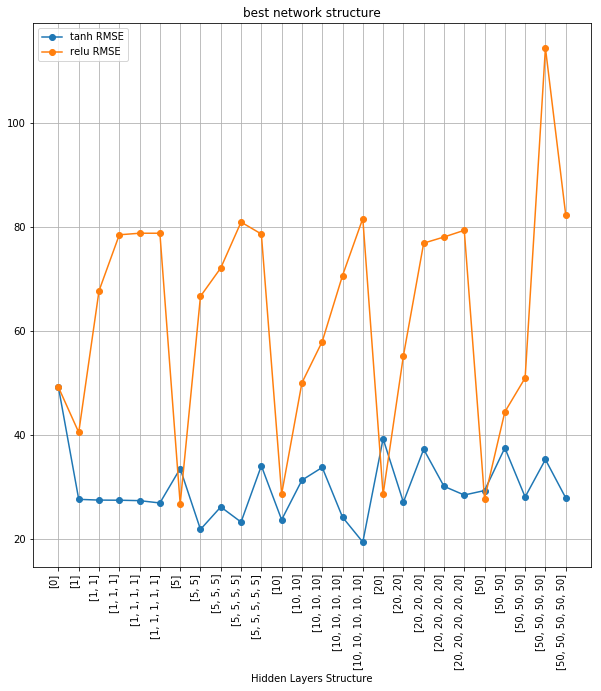

In [72]:
plt.figure(figsize=(10, 10))
plt.title('best network structure')
plt.plot(tanh_res, 'o-', label='tanh RMSE')
plt.plot(relu_res, 'o-', label='relu RMSE')
plt.legend()
plt.xticks(range(len(hiddens)), hiddens, rotation=90, horizontalalignment='right')
plt.xlabel('Hidden Layers Structure')
plt.grid(True)

It looks like tanh outperforms ReLU with this epoch, but this epoch was chosen from Tanh's results. If we use 875 epochs, from relu's performance, we get these results:

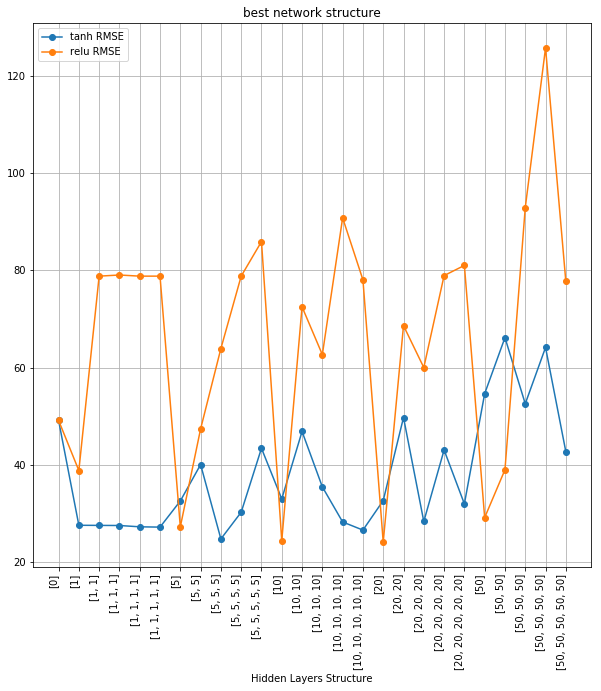

In [73]:
e650 = results[results['Epochs'] == 875]
e650_tanh = e650[e650['Activation'] == 'tanh'].sort_values('Hidden Units')
e650_relu = e650[e650['Activation'] == 'relu'].sort_values('Hidden Units')
hiddens = np.array(e650_tanh['Hidden Units'])
tanh_res = np.array(e650_tanh['RMSE Test'])
relu_res = np.array(e650_relu['RMSE Test'])
plt.figure(figsize=(10, 10))
plt.title('best network structure')
plt.plot(tanh_res, 'o-', label='tanh RMSE')
plt.plot(relu_res, 'o-', label='relu RMSE')
plt.legend()
plt.xticks(range(len(hiddens)), hiddens, rotation=90, horizontalalignment='right')
plt.xlabel('Hidden Layers Structure')
plt.grid(True)

ReLU still didn't do that well, but it still has the lowest performance for small nets, similar to before.

## Conclusion

It's really hard to tell if ReLU or TanH is better. It seems like epochs in that it varies for the data. Some datasets may perform better with ReLU over tanh. 

It seems like ReLU needs more epochs but can use smaller networks. This evaluation also uses unstandardized data. tanh has a maximum value where relu can output large values. This may have some impact that changes when the data is normalized. 